# Document Linearization to Markdown or HTML with Textractor

This example goes deeper on text linearization in Textractor. Text linearization is the conversion for a 2D document with words, lines, layouts and tables into a text string.

## Installation

To begin, install the `amazon-textract-textractor` package using pip.

`pip install amazon-textract-textractor`

There are various sets of dependencies available to tailor your installation to your use case. The base package will have sensible default, but you may want to install the PDF extra dependencies if your workflow uses PDFs with `pip install amazon-textract-textractor[pdf]`. You can read more on extra dependencies [in the documentation](https://aws-samples.github.io/amazon-textract-textractor/installation.html)

## Calling Textract

In [1]:
import os
from PIL import Image
from textractor import Textractor
from textractor.visualizers.entitylist import EntityList
from textractor.data.constants import TextractFeatures

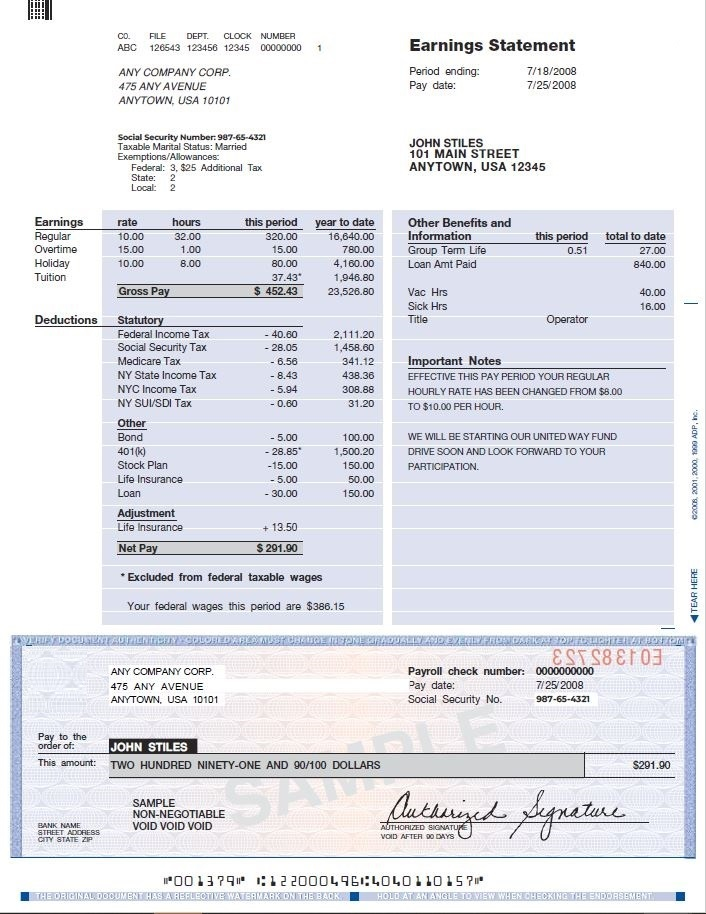

In [2]:
image = Image.open("../../../tests/fixtures/paystub.jpg").convert("RGB")
image

We can Textract's AnalyzeDocument API on this image. For the best possible extraction, we recommend using at least the `LAYOUT`, `TABLES` and `SIGNATURES` features to achieve the best possible reading order. OCR is always included with any AnalyzeDocument call. In this case we will also include `FORMS`.

In [3]:
extractor = Textractor(region_name="us-west-2")

document = extractor.analyze_document(
    file_source=image,
    features=[TextractFeatures.LAYOUT, TextractFeatures.TABLES, TextractFeatures.FORMS, TextractFeatures.SIGNATURES],
    save_image=True
)

Base linearization `.get_text()` is always available on all components of a document:

In [4]:
print(document.tables[0].get_text())

CO.	FILE	DEPT.	CLOCK	NUMBER
ABC	126543	123456	12345	00000000



However you can also use `.to_html()` and `.to_markdown()` to obtain the HTML and Markdown output respectively.

In [5]:
print(document.tables[0].to_html())

<table><tr><th>CO.</th><th>FILE</th><th>DEPT.</th><th>CLOCK</th><th>NUMBER</th></tr>
<tr><td>ABC</td><td>126543</td><td>123456</td><td>12345</td><td>00000000</td></tr>
</table>


In [6]:
print(document.tables[0].to_markdown())

| CO.    |   FILE  |   DEPT.  |   CLOCK  |   NUMBER  |
|--------|---------|----------|----------|-----------|
| ABC    | 126543  |  123456  |   12345  | 00000000  |


Both the HTML and Markdown options will use the table cell types to identify headers automatically.

You can apply your own configuration by building a `TextLinearizationConfig` object. Both `to_html()` and `.to_markdown()` are actually implemented as `TextLinearizationConfig` objects themselves. Say you wanted not to have header cells `<th>` in your table output, you could change the `HTMLLinearizationConfig` object and call `.get_text()` with it.

In [7]:
from textractor.data.html_linearization_config import HTMLLinearizationConfig

config = HTMLLinearizationConfig()
config.table_cell_header_prefix = "<td>"
config.table_cell_header_suffix = "</td>"

print(document.tables[0].get_text(config))

<table><tr><td>CO.</td><td>FILE</td><td>DEPT.</td><td>CLOCK</td><td>NUMBER</td></tr>
<tr><td>ABC</td><td>126543</td><td>123456</td><td>12345</td><td>00000000</td></tr>
</table>


## All entities can be linearized

This is not limited to tables, all entities have the `.get_text()`, `.to_html()` and `.to_markdown()` methods.

In [8]:
print(document.tables.to_markdown())

| CO.    |   FILE  |   DEPT.  |   CLOCK  |   NUMBER  |
|--------|---------|----------|----------|-----------|
| ABC    | 126543  |  123456  |   12345  | 00000000  |

|                |           |
|----------------|-----------|
| Period ending: | 7/18/2008 |
| Pay date:      | 7/25/2008 |

|          |                       |
|----------|-----------------------|
| Federal: | 3. $25 Additional Tax |
| State:   | 2                     |
| Local:   | 2                     |

| Earnings    | rate      | hours    | this period    | year to date    |
|-------------|-----------|----------|----------------|-----------------|
| Regular     | 10.00     | 32.00    | 320.00         | 16,640.00       |
| Overtime    | 15.00     | 1.00     | 15.00          | 780.00          |
| Holiday     | 10.00     | 8.00     | 80.00          | 4,160.00        |
| Tuition     |           |          | 37.43          | 1,946.80        |
|             | Gross Pay |          | $ 452.43       | 23,526.80       |

| Ot

In [9]:
print(document.key_values.get_text())

CO. ABC 

CLOCK 12345 

FILE 126543 

DEPT. 123456 

NUMBER 00000000 

Period ending: 7/18/2008 

Pay date: 7/25/2008 

Social Security Number: 987-65-4321 

Taxable Marital Status: Married 

Federal: 3. $25 Additional Tax 

JOHN STILES 101 MAIN STREET ANYTOWN, USA 12345 

State: 2 

Local: 2 

total to date 27.00 

Loan Amt Paid 840.00 

Vac Hrs 40.00 

Gross Pay $ 452.43 

Sick Hrs 16.00 

Title Operator 

HOURLY RATE HAS BEEN CHANGED FROM $8.00 

PER HOUR. $10.00 

Life Insurance + 13.50 

Net Pay $291.90 

Your federal wages this period are $386.15 

Payroll check number: 0000000000 

Pay date: 7/25/2008 

ANY COMPANY CORP. 475 ANY AVENUE ANYTOWN, USA 10101 

Social Security No. 987-65-4321 

Pay to the order of: JOHN STILES 

This amount: TWO HUNDRED NINETY-ONE AND 90/100 DOLLARS $291.90 

VOID AFTER 00 DAYS Authorized AUTHORIZED SIGNATURE Signature 

BANK NAME STREET ADDRESS CITY STATE ZIP SAMPLE NON-NEGOTIABLE VOID VOID VOID 


What if you are passing this to an LLM and would like to properly split key and values? You can use a custom `TextLinearizationConfig` to add special tokens that will act as a delimiter.

In [11]:
from textractor.data.text_linearization_config import TextLinearizationConfig

config = TextLinearizationConfig(
    key_prefix="<key>",
    key_suffix="</key>",
    value_prefix="<value>",
    value_suffix="</value>",
)
print(document.key_values.get_text(config))

<key>CO.</key><value>ABC </value>

<key>CLOCK</key><value>12345 </value>

<key>FILE</key><value>126543 </value>

<key>DEPT.</key><value>123456 </value>

<key>NUMBER</key><value>00000000 </value>

<key>Period ending:</key><value>7/18/2008 </value>

<key>Pay date:</key><value>7/25/2008 </value>

<key>Social Security Number:</key><value>987-65-4321 </value>

<key>Taxable Marital Status:</key><value>Married </value>

<key>Federal:</key><value>3. $25 Additional Tax </value>

<key>JOHN STILES</key><value>101 MAIN STREET ANYTOWN, USA 12345 </value>

<key>State:</key><value>2 </value>

<key>Local:</key><value>2 </value>

<key>total to date</key><value>27.00 </value>

<key>Loan Amt Paid</key><value>840.00 </value>

<key>Vac Hrs</key><value>40.00 </value>

<key>Gross Pay</key><value>$ 452.43 </value>

<key>Sick Hrs</key><value>16.00 </value>

<key>Title</key><value>Operator </value>

<key>HOURLY RATE HAS BEEN CHANGED FROM</key><value>$8.00 </value>

<key>PER HOUR.</key><value>$10.00 </value>

<k

We can now combine all the above to get a specially tailored output for your workflow

In [14]:
config = HTMLLinearizationConfig(
    table_cell_header_prefix = "<td>",
    table_cell_header_suffix = "</td>",
    key_prefix="<key>",
    key_suffix="</key>",
    value_prefix="<value>",
    value_suffix="</value>",
)
print(document.get_text(config))

1 



<table><tr><td>CO.</td><td>FILE</td><td>DEPT.</td><td>CLOCK</td><td>NUMBER</td></tr>
<tr><td>ABC</td><td>126543</td><td>123456</td><td>12345</td><td>00000000</td></tr>
</table>



ANY COMPANY CORP. 475 ANY AVENUE ANYTOWN, USA 10101 

<h2>Earnings Statement </h2>



<table><tr><td>Period ending:</td><td>7/18/2008</td></tr>
<tr><td>Pay date:</td><td>7/25/2008</td></tr>
</table>



 <key>Social Security Number:</key><value>987-65-4321 </value> <key>Taxable Marital Status:</key><value>Married </value> Exemptions/Allowances: 



<table><tr><td>Federal:</td><td>3. $25 Additional Tax</td></tr>
<tr><td>State:</td><td>2</td></tr>
<tr><td>Local:</td><td>2</td></tr>
</table>



 <key>JOHN STILES</key><value>101 MAIN STREET ANYTOWN, USA 12345 </value> 



<table><tr><td>Earnings</td><td>rate</td><td>hours</td><td>this period</td><td>year to date</td></tr>
<tr><td>Regular</td><td>10.00</td><td>32.00</td><td>320.00</td><td>16,640.00</td></tr>
<tr><td>Overtime</td><td>15.00</td><td>1.00</td><td

## Conclusion

In this tutorial, we have shown how the +50 configuration options of `TextLinearizationConfig` can be used to produce an output specifically tailored to your workflow.